# Self-Supervised Neural Networks Lab

Welcome to the self-supervised neural networks (SNN) lab! In this tutorial you will learn how to use unlabeled data to train models that learn useful representations, and then apply them to downstream tasks. We'll explore two domains: images and time series. The lab is based on the survey we prepared and follows the curriculum described previously.

Self-supervised learning (SSL) is an approach where a model learns to predict part of its input from other parts, generating supervisory signals from the data itself. This contrasts with fully supervised learning, which relies on manually annotated labels. In practice, SSL can dramatically reduce the need for labeled data and still produce high-quality representations.

There are two broad families of SSL methods:

- **Generative/self-predictive methods:** these methods train a model to reconstruct or predict part of the input (e.g., autoencoders, masked modeling, forecasting).
- **Discriminative/contrastive methods:** these methods train a model to distinguish between different augmented views of the data, pulling together representations of the same instance and pushing apart representations of different instances.

In this lab, we'll explore both families.

## Lab Outline

This lab is structured into four modules:

1. **Introduction to SSL** – Concepts and categories of self-supervised learning.
2. **Vision: rotation prediction and segmentation** – Learn a rotation prediction task and use the resulting features for digit classification.
3. **Time-series: autoencoder and classification** – Train an autoencoder on synthetic sine sequences and classify them based on embeddings.
4. **Evaluation and analysis** – Reflect on the results and discuss extensions.

Each module includes explanatory text followed by hands-on coding exercises. Feel free to experiment with the parameters and see how the outcomes change.

## Module 2 – Computer Vision: Rotation Prediction and Segmentation

We'll use the digits dataset from scikit-learn, which contains 1797 images of handwritten digits. Each image is 8×8 pixels, resulting in 64 features per sample. Pixel values are integers in the range 0 to 16. We'll begin by loading the dataset and visualizing some examples.

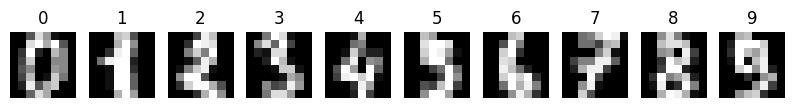

In [2]:

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load the digits dataset and split into features X and labels y
digits = load_digits()
X, y = digits.data, digits.target

# Visualize the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(str(digits.target[i]))
    ax.axis('off')
plt.show()

# Normalize pixel values to [0, 1]
X = X.astype('float32') / 16.0


In [ ]:

import numpy as np

# Create a dataset of rotated images for the pretext task
def create_rotation_dataset(X):
    images = X.reshape(-1, 8, 8)
    rotations = [0, 90, 180, 270]
    rot_images = []
    rot_labels = []
    for idx, angle in enumerate(rotations):
        k = (angle // 90) % 4
        for img in images:
            rotated = np.rot90(img, k=k)
            rot_images.append(rotated.flatten())
            rot_labels.append(idx)
    return np.array(rot_images, dtype=np.float32), np.array(rot_labels, dtype=np.int64)

rot_X, rot_y = create_rotation_dataset(X)
print("Rotation dataset size:", rot_X.shape)


In [ ]:

import numpy as np
from dataclasses import dataclass

@dataclass
class TwoLayerNet:
    # A simple two-layer neural network trained via gradient descent.
    input_dim: int
    hidden_dim: int
    output_dim: int
    learning_rate: float = 0.5

    def __post_init__(self):
        rng = np.random.default_rng(0)
        self.W1 = rng.standard_normal((self.input_dim, self.hidden_dim)) * 0.01
        self.b1 = np.zeros(self.hidden_dim)
        self.W2 = rng.standard_normal((self.hidden_dim, self.output_dim)) * 0.01
        self.b2 = np.zeros(self.output_dim)

    def forward(self, X):
        z1 = X.dot(self.W1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.W2) + self.b2
        exp_scores = np.exp(z2 - np.max(z2, axis=1, keepdims=True))
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        cache = (X, z1, a1, z2, probs)
        return probs, cache

    def backward(self, cache, y_true):
        X, z1, a1, z2, probs = cache
        n_samples = X.shape[0]
        one_hot = np.zeros_like(probs)
        one_hot[np.arange(n_samples), y_true] = 1
        dz2 = (probs - one_hot) / n_samples
        dW2 = a1.T.dot(dz2)
        db2 = dz2.sum(axis=0)
        da1 = dz2.dot(self.W2.T)
        dz1 = da1 * (1.0 - np.tanh(z1)**2)
        dW1 = X.T.dot(dz1)
        db1 = dz1.sum(axis=0)
        return dW1, db1, dW2, db2

    def update_params(self, dW1, db1, dW2, db2):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X, y, epochs=20, batch_size=128):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            idx = np.random.permutation(n_samples)
            X_shuf, y_shuf = X[idx], y[idx]
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuf[start:end]
                y_batch = y_shuf[start:end]
                probs, cache = self.forward(X_batch)
                grads = self.backward(cache, y_batch)
                self.update_params(*grads)

    def hidden_representation(self, X):
        z1 = X.dot(self.W1) + self.b1
        return np.tanh(z1)

    def predict(self, X):
        probs, _ = self.forward(X)
        return probs.argmax(axis=1)


In [ ]:

from sklearn.model_selection import train_test_split

# Instantiate the network
net = TwoLayerNet(input_dim=64, hidden_dim=32, output_dim=4, learning_rate=0.3)

# Split rotation dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(rot_X, rot_y, test_size=0.2, random_state=42)

# Train the network on the rotation task
net.train(X_train, y_train, epochs=15, batch_size=256)

# Evaluate on the validation set
val_preds = net.predict(X_val)
val_acc = (val_preds == y_val).mean()
print(f"Rotation classification accuracy: {val_acc:.2f}")


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Extract hidden representations for all digits
features = net.hidden_representation(X)

# Train/test split for downstream digit classification
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(features, y, test_size=0.3, random_state=1)

# Train a logistic regression classifier on the SSL features
clf_feat = LogisticRegression(max_iter=200, multi_class='auto', solver='lbfgs')
clf_feat.fit(X_train_d, y_train_d)
feat_acc = clf_feat.score(X_test_d, y_test_d)
print(f"Digit classification accuracy using SSL features: {feat_acc:.2f}")

# Baseline classifier on raw pixel values
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=1)
clf_base = LogisticRegression(max_iter=200, multi_class='auto', solver='lbfgs')
clf_base.fit(X_train_raw, y_train_raw)
base_acc = clf_base.score(X_test_raw, y_test_raw)
print(f"Baseline classification accuracy on raw pixels: {base_acc:.2f}")


In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform simple KMeans segmentation on the first digit image
sample_img = digits.images[0]
pixels = sample_img.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(pixels)
segmented = kmeans.labels_.reshape(sample_img.shape)

# Visualize the segmentation result
plt.imshow(segmented, cmap='gray')
plt.title("Simple KMeans segmentation of a digit")
plt.axis('off')
plt.show()


## Module 3 – Time Series: Autoencoder and Classification

In this module we switch to the time-series domain. We'll generate synthetic sine-wave sequences with two different frequencies and add Gaussian noise. The self-supervised task will be to reconstruct the sequences using an autoencoder (a generative self-supervised method). We will then classify the sequences based on the autoencoder's hidden representations and compare the performance to a classifier trained on raw sequences.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic sine sequences
def generate_sine_sequences(n_samples=1000, length=50, freq0=1.0, freq1=3.0, noise_std=0.1):
    t = np.linspace(0, 2 * np.pi, length)
    half = n_samples // 2
    seq0 = np.sin(freq0 * t)[None, :] * np.ones((half, 1))
    seq1 = np.sin(freq1 * t)[None, :] * np.ones((n_samples - half, 1))
    X = np.concatenate([seq0, seq1], axis=0)
    X += np.random.normal(scale=noise_std, size=X.shape)
    y = np.concatenate([np.zeros(half, dtype=int), np.ones(n_samples - half, dtype=int)])
    return X.astype(np.float32), y

X_ts, y_ts = generate_sine_sequences()

# Visualize one example from each class
plt.figure(figsize=(6, 3))
plt.plot(X_ts[0], label="Class 0")
plt.plot(X_ts[-1], label="Class 1")
plt.title("Example sine sequences")
plt.legend()
plt.show()


In [ ]:

import numpy as np
from dataclasses import dataclass

@dataclass
class Autoencoder:
    # A simple one-hidden-layer autoencoder for sequences.
    input_dim: int
    hidden_dim: int
    learning_rate: float = 0.1

    def __post_init__(self):
        rng = np.random.default_rng(1)
        self.W_enc = rng.standard_normal((self.input_dim, self.hidden_dim)) * 0.05
        self.b_enc = np.zeros(self.hidden_dim)
        self.W_dec = rng.standard_normal((self.hidden_dim, self.input_dim)) * 0.05
        self.b_dec = np.zeros(self.input_dim)

    def forward(self, X):
        z = X.dot(self.W_enc) + self.b_enc
        h = np.tanh(z)
        recon = h.dot(self.W_dec) + self.b_dec
        return h, recon

    def backward(self, X, h, recon):
        n_samples = X.shape[0]
        d_recon = (recon - X) / n_samples
        dW_dec = h.T.dot(d_recon)
        db_dec = d_recon.sum(axis=0)
        dh = d_recon.dot(self.W_dec.T)
        dz = dh * (1.0 - h**2)
        dW_enc = X.T.dot(dz)
        db_enc = dz.sum(axis=0)
        return dW_enc, db_enc, dW_dec, db_dec

    def update_params(self, dW_enc, db_enc, dW_dec, db_dec):
        self.W_enc -= self.learning_rate * dW_enc
        self.b_enc -= self.learning_rate * db_enc
        self.W_dec -= self.learning_rate * dW_dec
        self.b_dec -= self.learning_rate * db_dec

    def train(self, X, epochs=30, batch_size=64):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            idx = np.random.permutation(n_samples)
            X_shuf = X[idx]
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuf[start:end]
                h, recon = self.forward(X_batch)
                grads = self.backward(X_batch, h, recon)
                self.update_params(*grads)

    def encode(self, X):
        z = X.dot(self.W_enc) + self.b_enc
        return np.tanh(z)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the time series dataset
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_ts, y_ts, test_size=0.3, random_state=0)

# Normalize sequences to zero mean and unit variance
X_train_norm = (X_train_ts - X_train_ts.mean(axis=1, keepdims=True)) / (X_train_ts.std(axis=1, keepdims=True) + 1e-6)
X_test_norm = (X_test_ts - X_test_ts.mean(axis=1, keepdims=True)) / (X_test_ts.std(axis=1, keepdims=True) + 1e-6)

# Train the autoencoder
ae = Autoencoder(input_dim=X_train_norm.shape[1], hidden_dim=16, learning_rate=0.05)
ae.train(X_train_norm, epochs=30, batch_size=128)

# Encode sequences
train_emb = ae.encode(X_train_norm)
test_emb = ae.encode(X_test_norm)

# Classifier on autoencoder embeddings
clf_emb = LogisticRegression(max_iter=200, multi_class='auto', solver='lbfgs')
clf_emb.fit(train_emb, y_train_ts)
emb_acc = clf_emb.score(test_emb, y_test_ts)
print(f"Time-series classification accuracy using SSL features: {emb_acc:.2f}")

# Baseline classifier on raw normalized sequences
clf_raw = LogisticRegression(max_iter=200, multi_class='auto', solver='lbfgs')
clf_raw.fit(X_train_norm, y_train_ts)
raw_acc = clf_raw.score(X_test_norm, y_test_ts)
print(f"Baseline classification accuracy on raw sequences: {raw_acc:.2f}")


## Evaluation and Analysis

In the experiments above, you should observe that the rotation classifier performs significantly better than random guessing, indicating that the model has learned to understand orientation. However, the transfer of this representation to digit classification may not surpass a classifier trained directly on raw pixels (since the digits dataset is small and relatively easy to classify). The important takeaway is that self-supervised pretraining can produce non-trivial features even without labels.

For the time-series example, the autoencoder compresses each sequence into a lower-dimensional hidden vector. The classifier trained on these embeddings should perform comparably to the classifier trained on raw sequences, showing that the autoencoder has learned a useful representation that retains most of the information.

Here are some questions to consider:

- How would performance change if you increased the hidden dimension or the number of epochs?
- Can you think of other pretext tasks for images or time series (e.g., masking patches, permuting segments, predicting transformations)?
- How might contrastive methods (e.g., SimCLR or MoCo) improve the learned features compared to the simple autoencoder?